In [1]:
from matplotlib.ticker import AutoMinorLocator
from matplotlib import pyplot as plt

import seaborn as sns
import pandas as pd
import feather
import os.path

from polya.utils import smooth

sample="HeLaS3_r1"
drop_mtgenes = True

In [2]:
data_dir = "../data/external/flam-seq"
fname = {
    "HeLaS3_r1": "GSM3602165_hela_rep1_genomic_cleaned_gene_length.txt.gz",
    "HeLaS3_r2": "GSM3602166_hela_rep2_genomic_cleaned_gene_length.txt.gz",
}[sample]

fpath = os.path.join(data_dir, fname)
print( sample, fpath)

HeLaS3_r1 ../data/external/flam-seq/GSM3602165_hela_rep1_genomic_cleaned_gene_length.txt.gz


In [9]:
genepath = "/casa/joha/scripts/tailseeker3.1.7/refdb/level3/GRCh38/annotations-gene.feather"
df_gene = feather.read_dataframe(genepath)

## Mitochondrially-encoded genes
df_mtgenes = df_gene[df_gene["gene_description"].map(lambda x: x.startswith("mitochondrially encoded") if x else False)]
df_mtgenes = df_gene[df_gene["seqname"].map(lambda x: x == "chrM" if x else False)]
mtgenes = df_mtgenes["gene_name"]
print( len(mtgenes), "MT-encoded genes")

## TOP genes: The list is from Yamashita et al., NAR, 2008
topglist = [g.strip().upper() for g in open("../data/external/human_top_genes_nar_2008.csv", "rt").readlines()]
df_topgenes = df_gene[df_gene["gene_name"].isin(topglist)]
topgenes = df_topgenes["gene_name"]
print( len(topgenes), "TOP genes" )

## RP genes
df_rpgenes = df_gene[df_gene["gene_description"].map(lambda x: x.startswith("ribosomal protein") if x else False)]
df_rpgenes = df_rpgenes[df_rpgenes["gene_description"].map(lambda x: "kinase" not in x)]
df_rpgenes = df_rpgenes[df_rpgenes["gene_description"].map(lambda x: "like" not in x)]
df_rpgenes = df_rpgenes[df_rpgenes["gene_description"].map(lambda x: "binding" not in x)]
rpgenes = df_rpgenes["gene_name"]
print(len(df_rpgenes), "RP genes")

37 MT-encoded genes
89 TOP genes
1177 RP genes


In [10]:
### Load and preprocess the data
df = pd.read_table(fpath, sep=" ", compression="gzip")
print( len(df), "reads")

if drop_mtgenes is True: 
    df = df[~df["gene"].isin(mtgenes)]
    print( len(df), "reads for non-MT genes")
    
df = df.drop_duplicates(subset=["gene","umi"])
print( len(df), "reads after removing PCR duplicates" )

df.head(3)

/utp/joha/miniconda3/envs/polya/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


271711 reads
262997 reads for non-MT genes
261670 reads after removing PCR duplicates


,read,gene,umi,length,tail
1,m54099_180718_200058_10027435,TMSB10,TATGGGACAT,84,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...
2,m54099_180718_200058_10027544,BLCAP,AATTAACTCT,135,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...
3,m54099_180718_200058_10027567,B2M,CGGCCGTTCC,200,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...


Global poly(A) length distribution

No handles with labels found to put in legend.


../plots/global_pAlen_dists_HeLaS3_r1_FLAM-seq_10-220_wo_mtgenes_mini.pdf


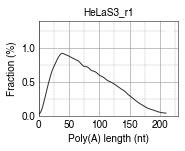

In [11]:
savefig = True
minifig = True

pAlen_range = [10, 220]; pr=pAlen_range
smoothing = True
smoothing_window=15
fmax = None

figsize = 5, 3.5
styles = ["../polya.mplstyle"]
if minifig is True: 
    styles.append("../mini.mplstyle")
    figsize = list(map(lambda x:x/2, figsize))

with plt.style.context(styles):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    
    pAlen_dist = df["length"].value_counts().sort_index().loc[pr[0]:pr[1]]
    pAlen_dist = pAlen_dist / pAlen_dist.sum() * 100 # fraction in percent
    
    if smoothing: pAlen_dist = smooth(np.array(pAlen_dist), window_len=smoothing_window)
        
    if fmax is None: fmax = pAlen_dist.max()
    elif fmax < pAlen_dist.max(): fmax = pAlen_dist.max()
    
    ax.plot(pAlen_dist)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2)) 
    ax.xaxis.grid(True, which='major', color='#878787', linestyle='-', lw=0.5)
    ax.xaxis.grid(True, which='minor', color='#878787', linestyle='--', lw=0.3)
    ax.yaxis.grid(True, which='major', color='#878787', linestyle='-', lw=0.5)
    ax.yaxis.grid(True, which='minor', color='#878787', linestyle='--', lw=0.3)
    ax.set_xlim([0,230])
#     ax.set_ylim([0, np.round(fmax * 1.1, 1)])
    ax.set_ylim([0,1.4])
    ax.set_xticks(range(0,250,50))
    ax.legend(loc="upper right", fontsize="medium", handlelength=1.0)#, ncol=2, columnspacing=0.1)
#     ax.legend(loc="center left", bbox_to_anchor=[1.01,0.5])
    ax.set_xlabel("Poly(A) length (nt)")
    ax.set_ylabel("Fraction (%)")
    ax.set_title("{}".format(sample), fontsize="medium")

    fname_adduct = ""
    if drop_mtgenes is True: fname_adduct += "_wo_mtgenes"
    if minifig is True: fname_adduct += "_mini"
        
    if savefig is True:
        outfigpath = "../plots/global_pAlen_dists_{}_FLAM-seq_{}-{}{}.pdf".format(sample, pr[0], pr[1], fname_adduct)
        print(outfigpath)
        fig.savefig(outfigpath, dpi=300, bbox_inches="tight")
        
    plt.show()

#### Moda poly(A) length scatter

In [12]:
pAlen_range = [10, 220]; pr=pAlen_range
minimum_pAtags = 200
df_ft = df.copy()
df_ft = df_ft[(df_ft["length"] >= pr[0]) & (df_ft["length"] <= pr[1])]
df_ft = df_ft.groupby("gene").filter(lambda gr: len(gr) >= minimum_pAtags)

pAmodes = df_ft.groupby("gene")["length"].agg(lambda x:x.value_counts().idxmax())
pAmeans = df_ft.groupby("gene")["length"].agg(np.mean)

../plots/modal_vs_mean_pAlen_HeLaS3_r1_FLAM-seq_10-220_wo_mtgenes_mini.pdf


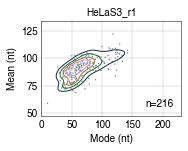

In [13]:
savefig = True
minifig = True

x = pAmodes
y = pAmeans

figsize = 5, 3.5
styles = ["../polya.mplstyle"]
if minifig is True: 
    styles.append("../mini.mplstyle")
    figsize = list(map(lambda x:x/2, figsize))

with plt.style.context(styles):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    
    ax.scatter(x, y, s=2, color="grey", edgecolor="none", rasterized=True)
    sns.kdeplot(x, y, n_levels=5, cmap="cubehelix", ax=ax)
    
    ax.text(x=0.95, y=0.1, s="n=%d"%(len(x)), ha="right", transform=ax.transAxes)
    ax.set_xlim([0,230])
#     ax.set_ylim([0,170])
    ax.set_xticks(range(0,250,50))
    ax.set_xlabel("Mode (nt)")
    ax.set_ylabel("Mean (nt)")
    ax.set_title(sample, fontsize="medium")
    ax.grid(True)

    fname_adduct = ""
    if drop_mtgenes is True: fname_adduct += "_wo_mtgenes"
    if minifig is True: fname_adduct += "_mini"

    if savefig is True:
        outfigpath = "../plots/modal_vs_mean_pAlen_{}_FLAM-seq_{}-{}{}.pdf".format(sample, pr[0], pr[1], fname_adduct)
        print(outfigpath)
        fig.savefig(outfigpath, dpi=300, bbox_inches="tight")
        
    plt.show()